### Instruction-Tuning LLMs: LoRA & HuggingFace


### Install necessary libraries

In [ ]:
!pip install -qq datasets==2.20.0
!pip install trl==0.9.6
!pip install transformers==4.42.3
!pip install peft==0.11.1
!pip install tqdm==4.66.4
!pip install numpy==1.26.4
!pip install pandas==2.2.2
!pip install matplotlib==3.9.1
!pip install seaborn==0.13.2
!pip install scikit-learn==1.5.1
!pip install sacrebleu==2.4.2 evaluate==0.4.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.5.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.8/245.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.8/113.8 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 66.6 MB/s eta 0:00:00
   ━━

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from datasets import load_dataset
import torch
from torch.utils.data import Dataset
from tqdm import tqdm
import evaluate
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM

from peft import get_peft_model, LoraConfig, TaskType

import pickle
import json
import matplotlib.pyplot as plt

from urllib.request import urlopen
import io
import pandas as pd
import numpy as np
import seaborn as sns

## Chosing cuda or cpu

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Data loading for instruction-tuning from huggingface

In [ ]:
#dataset = load_dataset("bigstupidhats/financial-instruction-aq22", split="train")
#dataset = load_dataset("DeividasM/financial-instruction-aq22", split="train")
#dataset = load_dataset("iamtarun/python_code_instructions_18k_alpaca", split="train")

dataset = load_dataset("qwedsacf/grade-school-math-instructions", split="train")


dataset

Generating train split:   0%|          | 0/8792 [00:00<?, ? examples/s]

Dataset({
    features: ['INSTRUCTION', 'RESPONSE', 'SOURCE'],
    num_rows: 8792
})

In [ ]:
pd.DataFrame(dataset[0:2])

,INSTRUCTION,RESPONSE,SOURCE
0,This math problem has got me stumped: Natalia ...,Natalia sold 48/2 = 24 clips in May.\nNatalia ...,grade-school-math
1,Weng earns $12 an hour for babysitting. Yester...,Weng earns 12/60 = $0.2 per minute.\nWorking 5...,grade-school-math


In [ ]:
#dataset = dataset.filter(lambda example: example["input"] == '')

In [ ]:
dataset = dataset.remove_columns(['SOURCE'])


In [ ]:
pd.DataFrame(dataset[0:2])

,INSTRUCTION,RESPONSE
0,This math problem has got me stumped: Natalia ...,Natalia sold 48/2 = 24 clips in May.\nNatalia ...
1,Weng earns $12 an hour for babysitting. Yester...,Weng earns 12/60 = $0.2 per minute.\nWorking 5...


In [ ]:
dataset = dataset.shuffle(seed=42)

In [ ]:
len(dataset['INSTRUCTION'])

8792

In [ ]:
# Reducing the size of the dataset

In [ ]:
dataset_split = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = dataset_split['train']
test_dataset = dataset_split['test']
dataset_split, train_dataset, test_dataset

(DatasetDict({
     train: Dataset({
         features: ['INSTRUCTION', 'RESPONSE'],
         num_rows: 7033
     })
     test: Dataset({
         features: ['INSTRUCTION', 'RESPONSE'],
         num_rows: 1759
     })
 }),
 Dataset({
     features: ['INSTRUCTION', 'RESPONSE'],
     num_rows: 7033
 }),
 Dataset({
     features: ['INSTRUCTION', 'RESPONSE'],
     num_rows: 1759
 }))

In [ ]:
# reduced_test_dataset=test_dataset.select(range(20))
# reduced_train_dataset=train_dataset.select(range(20))

### Loading model for instruction-tuning

In [ ]:
# Base model - unless fined tunted, it will be a base model. Once fine tuned, parameter will be updated
model = AutoModelForCausalLM.from_pretrained("facebook/opt-125m").to(device)

# This is a model used for comparing results - no changes will be made to model_base.
model_base = AutoModelForCausalLM.from_pretrained("facebook/opt-125m").to(device)


config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/251M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("facebook/opt-125m", padding_side='left') # Open Pre-trained Transformer (OPT)

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

In [ ]:
tokenizer.eos_token,tokenizer.bos_token

('</s>', '</s>')

In [ ]:
def formatting_prompts_func(mydataset):
    output_texts = []
    for i in range(len(mydataset['INSTRUCTION'])):
        text = (
            f"### Instruction:\n{mydataset['INSTRUCTION'][i]}"
            f"\n\n### Response:\n{mydataset['RESPONSE'][i]}</s>"
        )
        output_texts.append(text)
    return output_texts


### Setting up LoRA configuration

In [ ]:
lora_config = LoraConfig(
    r=16,  # Low-rank dimension
    lora_alpha=32,  # Scaling factor
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,  # Dropout rate
    task_type=TaskType.CAUSAL_LM  # Task causal language model
)

model = get_peft_model(model, lora_config)

In [ ]:
response_template = "### Response:\n"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

## Setting up training parameters

In [ ]:
training_args = SFTConfig(
    output_dir="/tmp",
    num_train_epochs=50,
    save_strategy="epoch",
    fp16=True,
    per_device_train_batch_size=2,  # Reduce batch size
    per_device_eval_batch_size=2,  # Reduce batch size
    max_seq_length=1024,
    do_eval=True
)

trainer = SFTTrainer(
    model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    formatting_func=formatting_prompts_func,
    args=training_args,
    packing=False,
    data_collator=collator,
)

Map:   0%|          | 0/1759 [00:00<?, ? examples/s]

## Training start

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
500,2.225700
1000,2.056900
1500,1.969100
2000,1.943500
2500,1.902200
3000,1.855600
3500,1.883600
4000,1.803800
4500,1.804200
5000,1.765600


TrainOutput(global_step=175850, training_loss=1.310331710542099, metrics={'train_runtime': 10809.0778, 'train_samples_per_second': 32.533, 'train_steps_per_second': 16.269, 'total_flos': 3.109739763200717e+16, 'train_loss': 1.310331710542099, 'epoch': 50.0})

### Visualize Training Error

In [ ]:
log_history = trainer.state.log_history


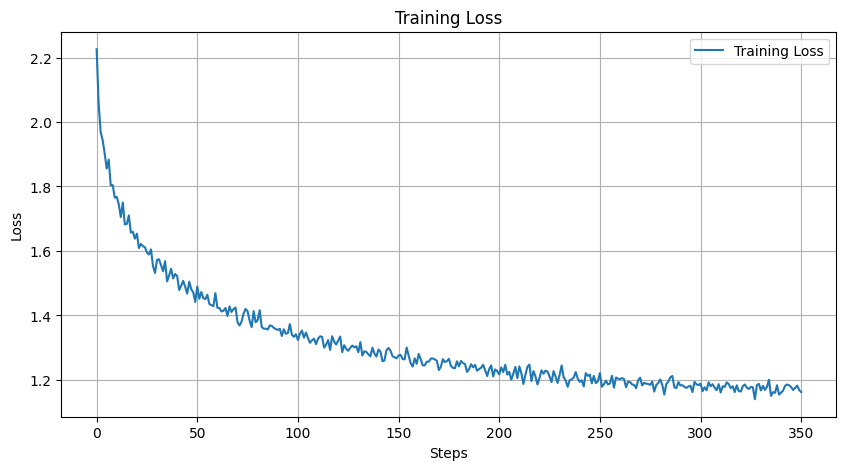

In [ ]:
train_loss = [log["loss"] for log in log_history if "loss" in log]

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

### Inference/Testing Time

In [ ]:
def formatting_prompts_func_no_response(mydataset):
    output_texts = []
    for i in range(len(mydataset['INSTRUCTION'])):
        text = (
            f"### Instruction:\n{mydataset['INSTRUCTION'][i]}"
            f"\n\n### Response:\n"
        )
        output_texts.append(text)
    return output_texts


In [ ]:
only_instructions = formatting_prompts_func_no_response(test_dataset)


In [ ]:
print(only_instructions[0])

### Instruction:
In a grocery store, the daily salary of the manager is $5 and the clerk is $2. If there are currently 2 managers and 3 clerks employed in the grocery store, how much is the total daily salary of all the employees of the grocery store?
Give me a detailed solution. 

### Response:



In [ ]:
class ListDataset(Dataset):
    def __init__(self, original_list):
        self.original_list = original_list

    def __len__(self):
        return len(self.original_list)

    def __getitem__(self, i):
        return self.original_list[i]

instructions_final = ListDataset(only_instructions)

##  Result from instruction tuned model

In [ ]:
gen_pipeline = pipeline("text-generation",
                        model=model,
                        tokenizer=tokenizer,
                        device=device,
                        batch_size=2,
                        max_length=1000,
                        truncation=True,
                        padding=False,
                        return_full_text=False)

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MixtralForCausalLM', 'MptForCausalLM'

In [ ]:
tokenizer.padding_side = 'left'

with torch.no_grad():
    pipeline_iterator= gen_pipeline(instructions_final[:5],
                                    max_length=500,
                                    num_beams=5,
                                    early_stopping=True,)

generated_outputs_base = []
for text in pipeline_iterator:
    generated_outputs_base.append(text[0]["generated_text"])

## Responses from instruction-tuned model are ok. It is just a simple demo

In [ ]:
for i in range(len(generated_outputs_base)):
  print('---------------------')
  print(i)
  print(instructions_final[i])
  print('\n')
  print(generated_outputs_base[i])
  print('---------------------')
  print('\n')

---------------------
0
### Instruction:
In a grocery store, the daily salary of the manager is $5 and the clerk is $2. If there are currently 2 managers and 3 clerks employed in the grocery store, how much is the total daily salary of all the employees of the grocery store?
Give me a detailed solution. 

### Response:



The manager's daily salary is $5 x 2 = $10.
The clerks' daily salary is $2 x 3 = $6.
The total daily salary of all the employees of the grocery store is $10 + $6 = $14.
---------------------


---------------------
1
### Instruction:
Can you break down the solution for me for this math problem: At the Bertolli Farm, they grow 2073 tomatoes, 4112 cobs of corn, and 985 onions. How many fewer onions are grown than tomatoes and corn together?

### Response:



At the Bertolli Farm, there are 2073 + 4112 + 985 = 542 cobs of corn.
At the Bertolli Farm, there are 4112 - 542 = 542 cobs of corn.
At the Bertolli Farm, there are 542 - 542 = 542 cobs of corn.
Altogether, at the B

## Generating responses from base model

In [ ]:
gen_pipeline = pipeline("text-generation",
                        model=model_base,
                        tokenizer=tokenizer,
                        device=device,
                        batch_size=2,
                        max_length=200,
                        truncation=True,
                        padding=False,
                        return_full_text=False)

In [ ]:
tokenizer.padding_side = 'left'

with torch.no_grad():
    # Due to resource limitation, only apply the function on 3 records using "instructions_torch[:10]"
    pipeline_iterator= gen_pipeline(instructions_final[:3],
                                    max_length=500, # this is set to 50 due to resource constraint, using a GPU, you can increase it to the length of your choice
                                    num_beams=5,
                                    early_stopping=True,)

generated_outputs_base = []
for text in pipeline_iterator:
    generated_outputs_base.append(text[0]["generated_text"])

In [ ]:
for i in range(len(generated_outputs_base)):
  print('---------------------')
  print(i)
  print(instructions_final[i])
  print(generated_outputs_base[i])
  print('---------------------')
  print('\n')

---------------------
0
### Instruction:
In a grocery store, the daily salary of the manager is $5 and the clerk is $2. If there are currently 2 managers and 3 clerks employed in the grocery store, how much is the total daily salary of all the employees of the grocery store?
Give me a detailed solution. 

### Response:

In a grocery store, the daily salary of the manager is $5 and the clerk is $2. If there are currently 2 managers and 3 clerks employed in the grocery store, how much is the total daily salary of all the employees of the grocery store?
Give me a detailed solution.

### Response:
In a grocery store, the daily salary of the manager is $5 and the clerk is $2. If there are currently 2 managers and 3 clerks employed in the grocery store, how much is the total daily salary of all the employees of the grocery store?
Give me a detailed solution.

### Response:
In a grocery store, the daily salary of the manager is $5 and the clerk is $2. If there are currently 2 managers and 3 c

#### Responses from the base model are very poor